In [1]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score as r2_score
from sklearn.metrics import mean_squared_error as mse

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [18, 10]

## Importing Dataset

In [3]:
df = pd.read_csv("../../Dataset/Gold.csv")
df

,Date,Open,Close,High,Low
0,2018-01-01,1300.760,1313.075,1316.08375,1300.6425
1,2018-01-02,1302.910,1316.500,1318.91000,1302.8550
2,2018-01-03,1318.375,1318.875,1321.30000,1307.7100
3,2018-01-04,1313.105,1327.875,1327.87500,1306.0500
4,2018-01-05,1322.050,1319.590,1323.50500,1313.9100
...,...,...,...,...,...
2339,2024-05-28,2352.200,2361.310,2363.46000,2340.4200
2340,2024-05-29,2361.390,2339.110,2361.79000,2335.0700
2341,2024-05-30,2338.880,2343.380,2351.09000,2323.0300
2342,2024-05-31,2343.340,2327.820,2359.58000,2320.6300


In [4]:
df.dtypes

Date      object
Open     float64
Close    float64
High     float64
Low      float64
dtype: object

In [5]:
df = df[["Close"]]
df.reset_index(drop=True)

,Close
0,1313.075
1,1316.500
2,1318.875
3,1327.875
4,1319.590
...,...
2339,2361.310
2340,2339.110
2341,2343.380
2342,2327.820


In [6]:
df.head()

,Close
0,1313.075
1,1316.500
2,1318.875
3,1327.875
4,1319.590


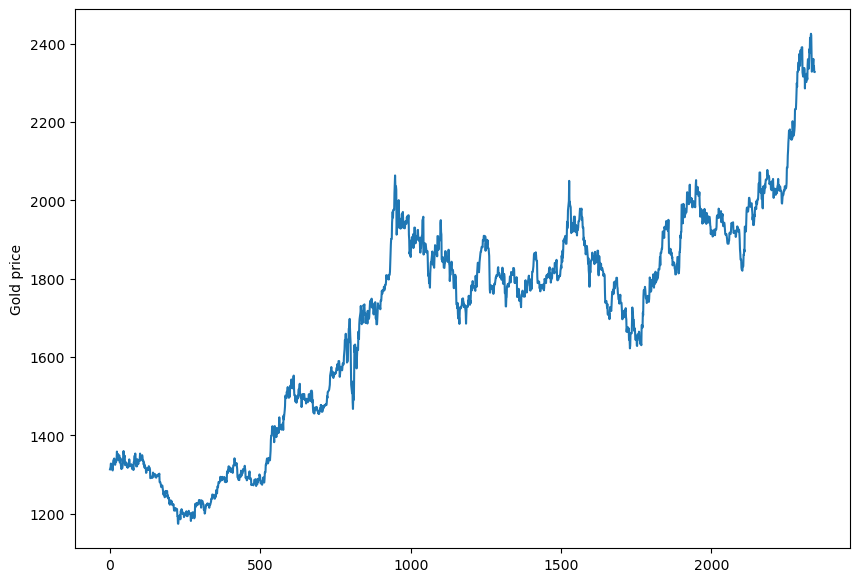

In [7]:
#Đồ thị giá đóng
df.Close.plot(figsize = (10, 7))
plt.ylabel("Gold price")
plt.show()


In [8]:
#train test split
train_size = int(0.8 * len(df))

train_df = df[:train_size]
test_df = df[train_size:]

In [9]:
def optimize_ETS(train_df, param_list):
    results = []
    endog = train_df['Close'].to_numpy()
    
    for order in tqdm_notebook(param_list):
        if order[4] == True and order[1] == None:
            continue
        else:
            model = ETSModel(endog,
                             error = order[0],
                             trend = order[1],
                             seasonal = order[2],
                             damped_trend = order[4],
                             seasonal_periods = order[3]).fit()
              
            aic = model.aic
            mse = model.mse
            results.append([order, aic, mse])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(e, t, s)", "AIC", "MSE"]
    #Sort in ascending order, lower MSE is better
    result_df = result_df.sort_values(by='MSE', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
e = ['add', 'mul']
t = ['add', 'mul', None]
s = ['add', 'mul', None]
p = [7, 30, 90]
d = [True, False]

param_list = list(product(e,t,s,p,d))

In [11]:
result_df = optimize_ETS(train_df, param_list)
result_df

  0%|          | 0/108 [00:00<?, ?it/s]

,"(e, t, s)",AIC,MSE
0,"(mul, add, mul, 90, False)",14842.605571,0.000057
1,"(mul, mul, mul, 90, False)",14843.239275,0.000057
2,"(mul, mul, mul, 90, True)",14845.301550,0.000057
3,"(mul, None, mul, 90, False)",14839.732213,0.000057
4,"(mul, add, mul, 90, True)",14845.737904,0.000057
...,...,...,...
85,"(add, mul, add, 7, False)",14991.519201,171.354271
86,"(add, add, mul, 7, False)",14991.919918,171.390896
87,"(add, None, add, 30, False)",15119.570191,179.401630
88,"(add, mul, add, 30, False)",15124.593129,179.499532


In [12]:
model = ETSModel(
    train_df['Close'],
    error="mul",
    trend="add",
    seasonal="mul",
    damped_trend=False,
    seasonal_periods=90)

res = model.fit()
print(res.summary())

                                 ETS Results                                  
Dep. Variable:                  Close   No. Observations:                 1875
Model:                       ETS(MAM)   Log Likelihood               -7325.303
Date:                Thu, 13 Jun 2024   AIC                          14842.606
Time:                        11:31:23   BIC                          15374.097
Sample:                             0   HQIC                         15038.396
                               - 1875   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9992      0.023     43.815      0.000       0.955       1.044
smoothing_trend      9.992e-05        nan        nan        nan         nan         nan
smoothing_season

## FORECASTING

In [13]:
predicted = res.predict(start = len(train_df), end = len(train_df) + len(test_df) - 1)

In [14]:
mape = np.mean(np.abs(predicted - test_df['Close'])/np.abs(test_df['Close'])) *100
mse = np.mean(np.square(test_df['Close'] - predicted))
rmse = np.sqrt(mse)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Percentage Error (MAPE): 6.897714050996701
Mean Squared Error (MSE): 36337.61230130248
Root Mean Squared Error (RMSE): 190.62426996923156


In [15]:
# Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Predict the closing prices for the next 90 days
y_next_90_days = res.predict(start = len(df), end = len(df) + 90 - 1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
2344    1923.935231
2345    1925.295619
2346    1921.383054
2347    1925.560672
2348    1921.490157
           ...     
2429    1941.975804
2430    1944.054009
2431    1947.228291
2432    1948.855612
2433    1950.163580
Length: 90, dtype: float64


In [16]:
dt_train = np.append(train_df, predicted.iloc[0]) 

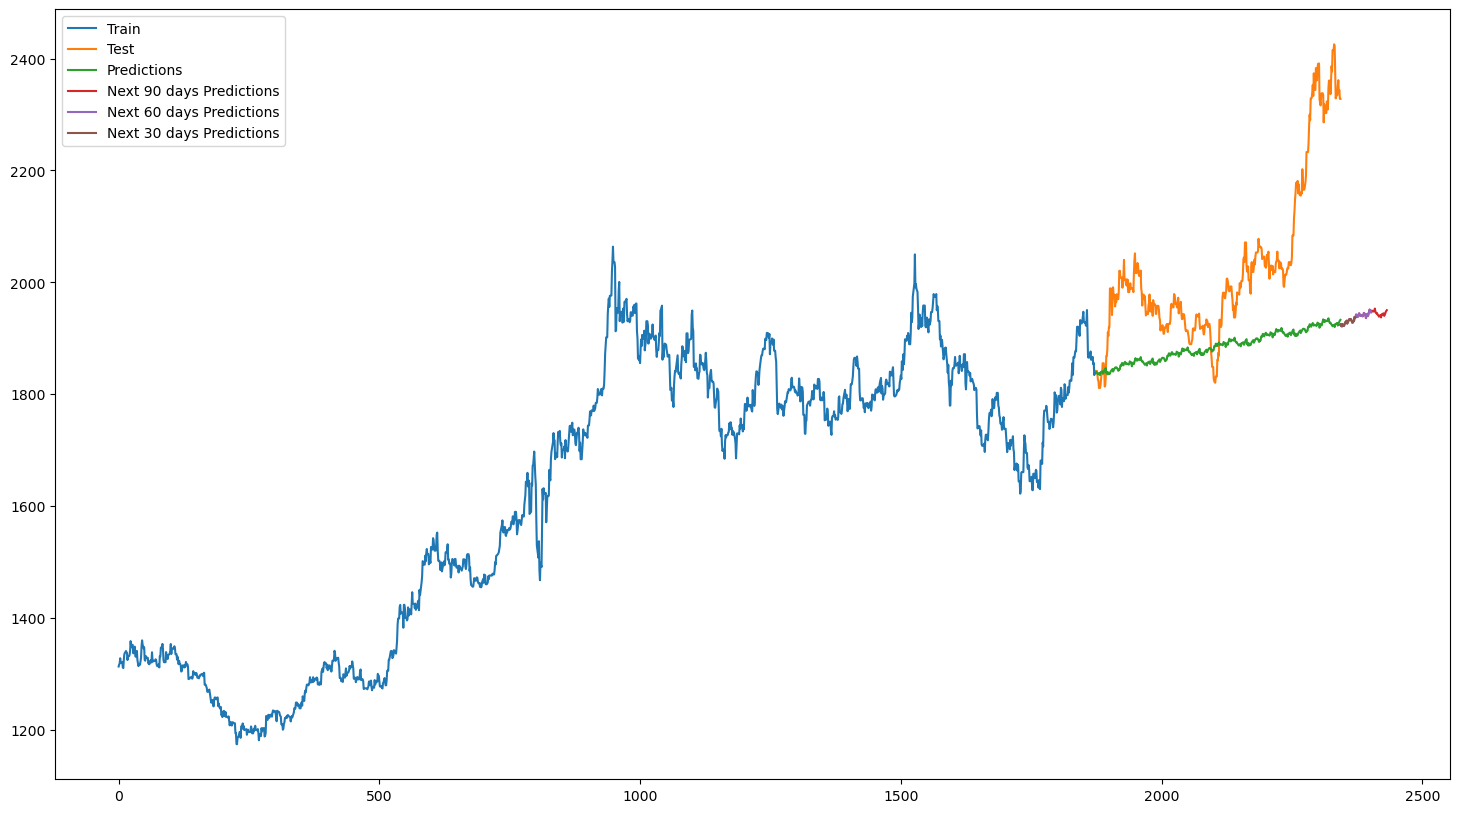

In [17]:
fig, ax = plt.subplots()

plt.plot(pd.RangeIndex(start=0, stop=len(dt_train), step=1), dt_train)
plt.plot(test_df.index, test_df)
plt.plot(test_df.index, predicted)
plt.plot(last_data,y_next_90_days)
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+60, step=1),y_next_90_days[0:60])
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+30, step=1),y_next_90_days[0:30])
plt.legend(['Train', 'Test', 'Predictions', 'Next 90 days Predictions', 'Next 60 days Predictions', 'Next 30 days Predictions'])
plt.show()
